In [1]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold 
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import permutations
from copy import deepcopy
from sklearn.metrics import accuracy_score, silhouette_score, davies_bouldin_score
import bisect

In [2]:
workload_data = pd.read_csv(index_col=0, filepath_or_buffer='data.csv')
labeled_data = pd.read_csv(index_col=0, filepath_or_buffer='labels.csv')

In [3]:
# Quick look at what we're working with
unique = np.unique(labeled_data)
# Check how many labels there are
print(len(unique))
labeled_data_items = labeled_data.values.flatten()

# Inserting the labels into a dict for easy access
label_indices = dict()
for item in unique:
    indices = [idx for idx, label in enumerate(labeled_data_items) if item == label]
    label_indices[item] = indices

5


Q1.1 Task 1:
- Are there missing values? Look on their website of the data to see how missing values are coded
Answer: It says on the website that the missing values are "N/A", but there aren't any (which can be seen in the code below)
- Compute the means and variances of the features (visualise in a histogram or with a kernel density estimate). Do they vary widely?
Answer: They do vary quite a lot yes, however they bot vary in mean quite normally, and for variance quite logarithmic.
- Are there constant features?
Answer: There are 267 columns with a variance of 0 (where they are full of 0s) and 14944 columns with a variance of less than 2.

In [4]:
contains_missing_values = workload_data.isna()
columns_with_missing_values = 0
for column_name in workload_data.columns: 
    if sum(contains_missing_values[column_name]) > 0:
        columns_with_missing_values += 0
print(f'Amount of columns with missing values: {columns_with_missing_values}')
means = workload_data.mean()

variances = workload_data.var()
n_of_constant_values = variances[variances == 0]
n_of_low_var_values = variances[variances < 2.2]
print(f'Number of columns with variance = 0: {len(n_of_constant_values)} st')
print(f'Number of columns with variance < 2.2: {len(n_of_low_var_values)} st')
print(f'Amount of columns that are completely full of 0s: {sum([1 for x in means if x == 0])}')
print(f'There are about 15000 columns below a variance of 2, so we will remove all columns below a variance of 2 later to get our refined dataset')

Amount of columns with missing values: 0
Number of columns with variance = 0: 267 st
Number of columns with variance < 2.2: 15457 st
Amount of columns that are completely full of 0s: 267
There are about 15000 columns below a variance of 2, so we will remove all columns below a variance of 2 later to get our refined dataset


In [5]:
for column_name in workload_data.columns: 
    if sum(contains_missing_values[column_name]) > 0:
        print(f'{column_name=}')
print(f'No missing values, all gene_values are numeric values')
means = workload_data.mean()
variances = workload_data.var()
variance_threshold = 2.2
n_of_sub_constant_values = variances[variances < variance_threshold]
print(f'Number of columns with variance < 2.2: {len(n_of_sub_constant_values)} st')
print(f'There are about 15000 columns below a variance of 2, so we will reduce all columns below a variance of 2 later to get our refined dataset')

No missing values, all gene_values are numeric values
Number of columns with variance < 2.2: 15457 st
There are about 15000 columns below a variance of 2, so we will reduce all columns below a variance of 2 later to get our refined dataset


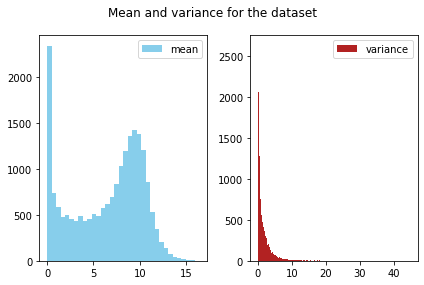

They do vary quite widely yes


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the dataset')
ax1.hist(means, bins='auto', color='skyblue', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='firebrick')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do vary quite widely yes')

Q1.1 Task 2:

In [7]:
trimmed_data = deepcopy(workload_data)
data_columns = trimmed_data.columns
selector = VarianceThreshold(threshold=variance_threshold)

# rename them with same index and column names
columns_data = [f'gene_{i}' for i in range(1, 5072)]
rows_data = [f'sample_{i}' for i in range(1, 802)]
trimmed_data = pd.DataFrame(selector.fit_transform(trimmed_data), columns=columns_data, index=rows_data)

        

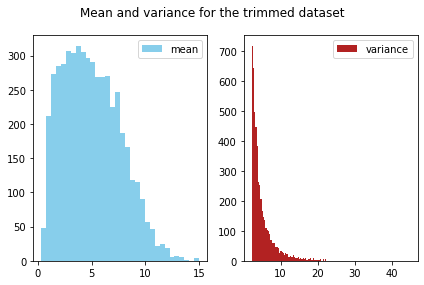

They do look alot better right now, gaussian and logarithmic


In [8]:
means = trimmed_data.mean()
variances = trimmed_data.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed dataset')
ax1.hist(means, bins='auto', color='skyblue', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='firebrick')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do look alot better right now, gaussian and logarithmic')

C:\Users\rasmu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


-1.0664383410303971e-17 4.967426499299451


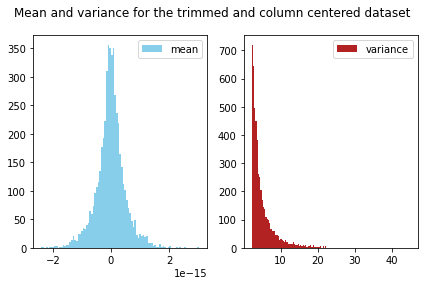

In [9]:
# Plot a normalised version to check if needed
colcentered_df=(trimmed_data-trimmed_data.mean())
# Just checking it works
print(np.mean(np.mean(colcentered_df)), np.mean(np.var(colcentered_df)))

means = np.mean(colcentered_df)
variances = np.var(colcentered_df)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed and column centered dataset')
ax1.hist(means, bins='auto', label='mean', color='skyblue')
ax2.hist(variances, bins='auto', label='variance', color='firebrick')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()


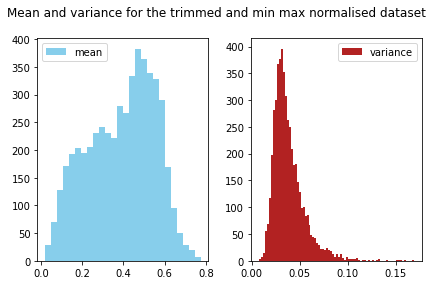

The min max version looks very similar to the original, might be an indication its not really needed


In [10]:
# Checking for max-min normalizing as well
min_max_df=(trimmed_data-trimmed_data.min())/(trimmed_data.max()-trimmed_data.min())

means = min_max_df.mean()
variances = min_max_df.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed and min max normalised dataset')
ax1.hist(means, bins='auto', label='mean', color='skyblue')
ax2.hist(variances, bins='auto', label='variance', color='firebrick')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'The min max version looks very similar to the original, might be an indication its not really needed')

In [11]:
n_components = 10
pca = PCA(n_components)
principalComponents = pca.fit_transform(colcentered_df)
print(principalComponents.shape)

(801, 10)


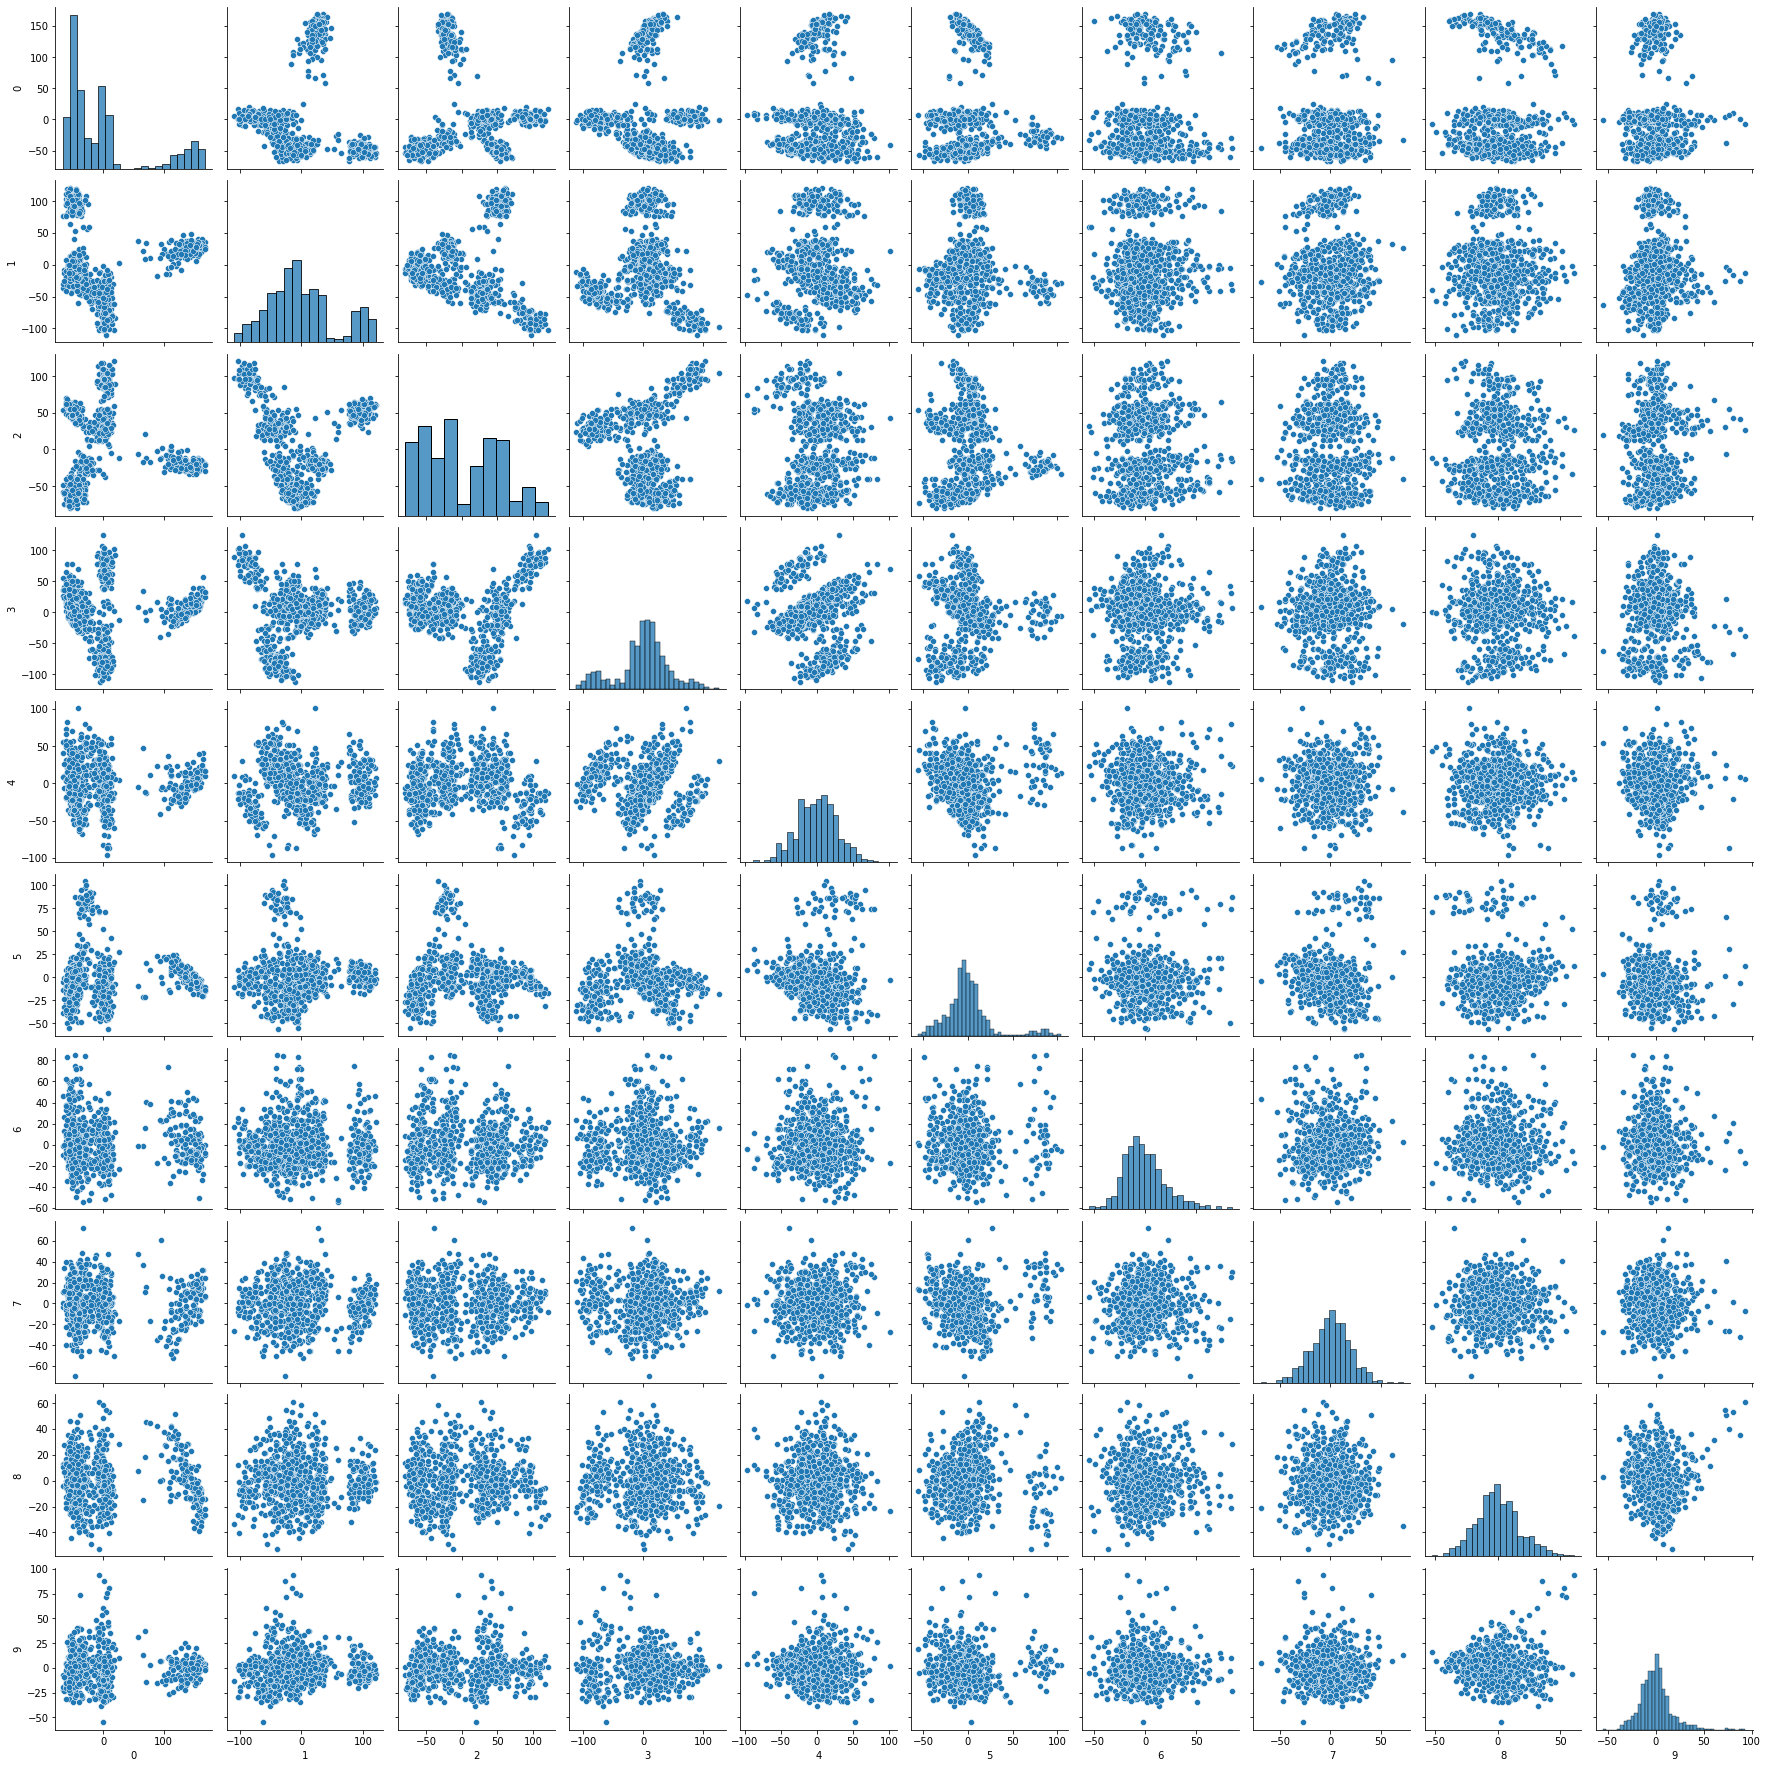

In [12]:
# principal component analysis
n_pc = 10
pca = PCA(n_components=n_pc)
principalComponents = pca.fit_transform(colcentered_df)
principalComponents_df = pd.DataFrame(principalComponents)

sns.pairplot(principalComponents_df, palette='blue')

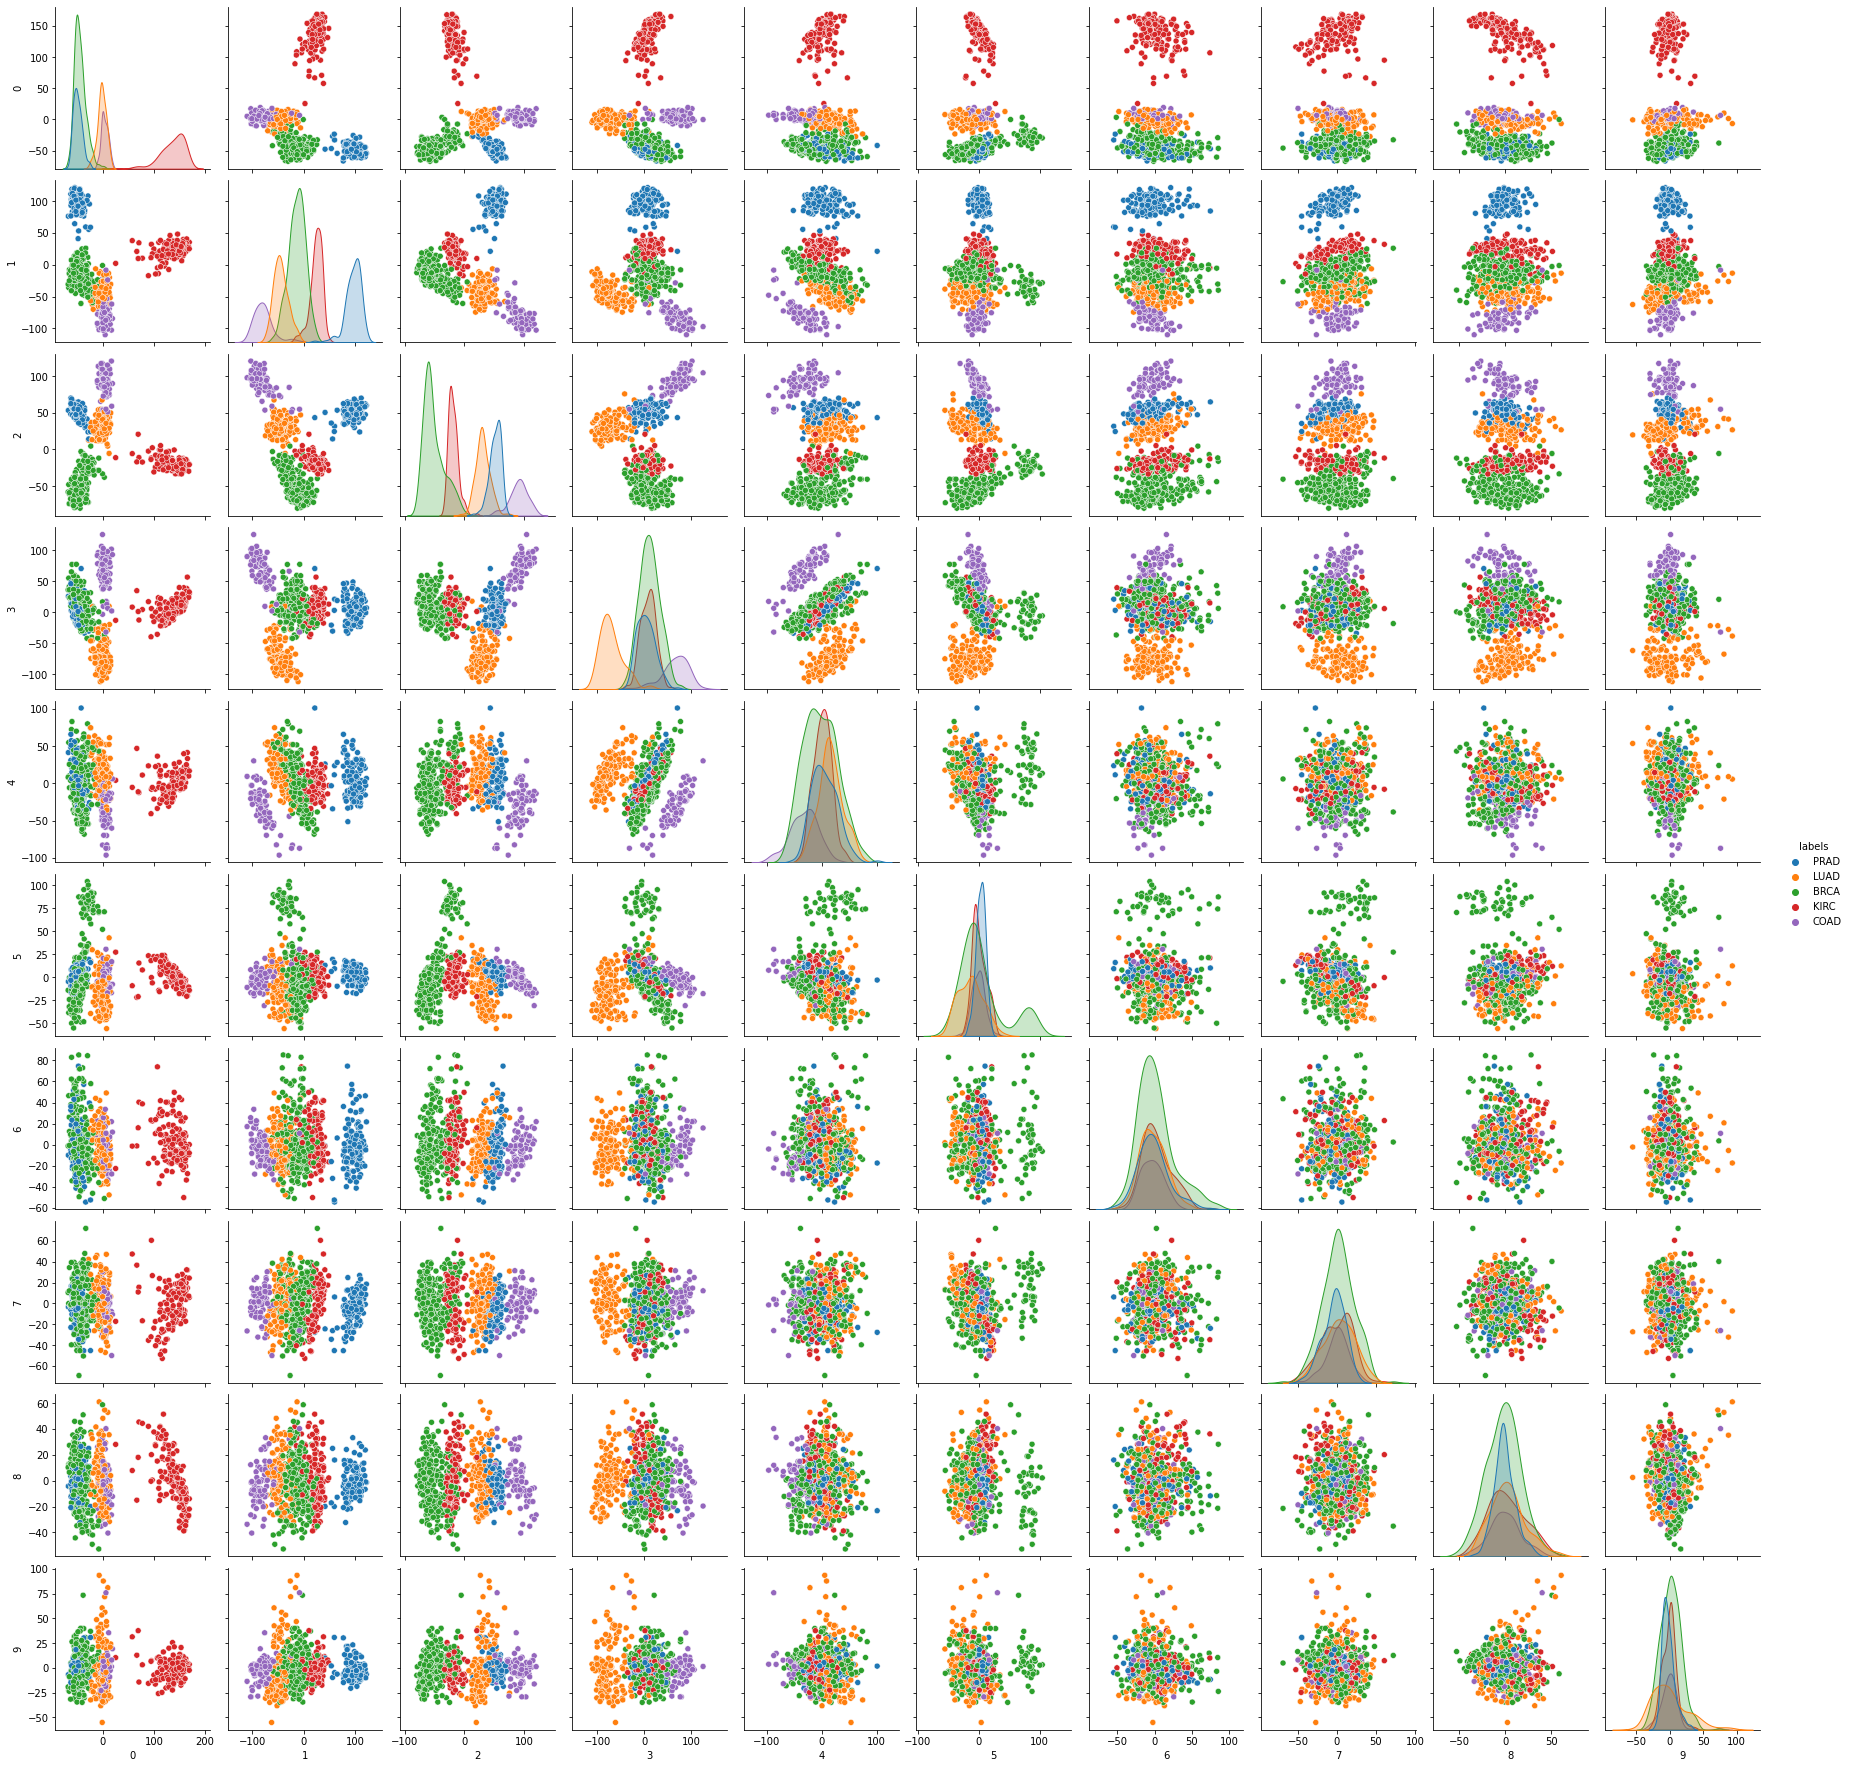

In [13]:
principalComponents_df_labeled = deepcopy(principalComponents_df)
principalComponents_df_labeled['labels'] = labeled_data.values
sns.pairplot(principalComponents_df_labeled, hue='labels', palette='tab10')

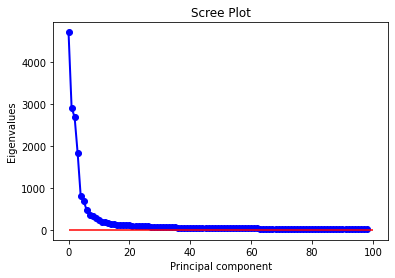

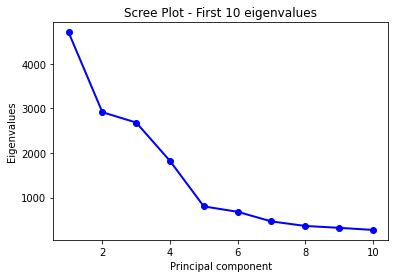

In [14]:
n_pc = 100
pca = PCA(n_components=n_pc)
pca.fit_transform(colcentered_df)
lambdas = pca.explained_variance_
# print(pca.explained_variance_)
a = 0
b = -1
lamb_trimmed = lambdas[a:b]

plt.plot(lamb_trimmed, 'o-', linewidth=2, color='blue')
plt.hlines(y=1, xmin=0, xmax=100, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal component')
plt.ylabel('Eigenvalues')
plt.show()



plt.plot(range(1,11), lamb_trimmed[0:10], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot - First 10 eigenvalues')
plt.xlabel('Principal component')
plt.ylabel('Eigenvalues')
plt.show()

Q1.2 Task 4

In [15]:
# time for clustering
n_pc = 5
pca = PCA(n_components=n_pc)
principalComponents = pca.fit_transform(colcentered_df)

max_number_clusters = 7
cluster_sizes = range(2, max_number_clusters)
n_runs = 20
kmeans_s_scores = []
gmm_s_scores = []
dbscan_s_scores = []
kmeans_db_scores = []
gmm_db_scores = []
kmeans_inertias = []
gmm_bics = []
for n_clusters in cluster_sizes:
    kmeans_s_score = 0
    gmm_s_score = 0
    kmeans_db_score = 0
    kmeans_inertia = 0
    gmm_bic = 0
    for _ in range(n_runs):
        # fit kmeans
        KM_model = KMeans(n_clusters=n_clusters)
        KM_model.fit(principalComponents)
        prediction_kmeans = KM_model.predict(principalComponents)
        # fit gmm
        GM_model = GaussianMixture(n_components=n_clusters)
        GM_model.fit(principalComponents)
        prediction_gmm = GM_model.predict(principalComponents)
        # kmeans scores
        kmeans_s_score =+ silhouette_score(principalComponents, prediction_kmeans)
        kmeans_db_score =+ davies_bouldin_score(principalComponents, prediction_kmeans)
        kmeans_inertia =+ KM_model.inertia_
        # gmm scores        
        gmm_s_score =+ silhouette_score(principalComponents, prediction_gmm)
        gmm_db_score =+ davies_bouldin_score(principalComponents, prediction_gmm)
        gmm_bic =+ GM_model.bic(principalComponents)
        
    kmeans_s_scores.append(kmeans_s_score/n_runs)
    gmm_s_scores.append(gmm_s_score/n_runs)
    kmeans_db_scores.append(kmeans_db_score/n_runs)
    gmm_db_scores.append(gmm_db_score/n_runs)
    kmeans_inertias.append(kmeans_inertia/n_runs)
    gmm_bics.append(gmm_bic/n_runs)

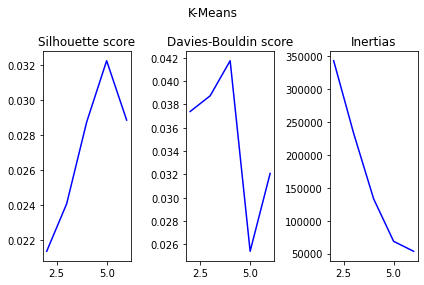

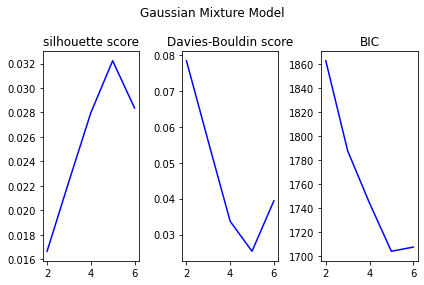

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(cluster_sizes, kmeans_s_scores, color='blue')
ax1.set_title('Silhouette score')
ax2.plot(cluster_sizes, kmeans_db_scores, color='blue')
ax2.set_title('Davies-Bouldin score')
ax3.plot(cluster_sizes, kmeans_inertias, color='blue')
ax3.set_title('Inertias')
fig.suptitle('K-Means')
plt.tight_layout()
plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(cluster_sizes, gmm_s_scores, color='blue')
ax1.set_title('silhouette score')
ax2.plot(cluster_sizes, gmm_db_scores, color='blue')
ax2.set_title('Davies-Bouldin score')
ax3.plot(cluster_sizes, gmm_bics, color='blue')
ax3.set_title('BIC')
fig.suptitle('Gaussian Mixture Model')
plt.tight_layout()
plt.show()

In [17]:
# If we want to change the pca count
n_pc = 5
pca = PCA(n_components=n_pc)
principalComponents = pca.fit_transform(colcentered_df)

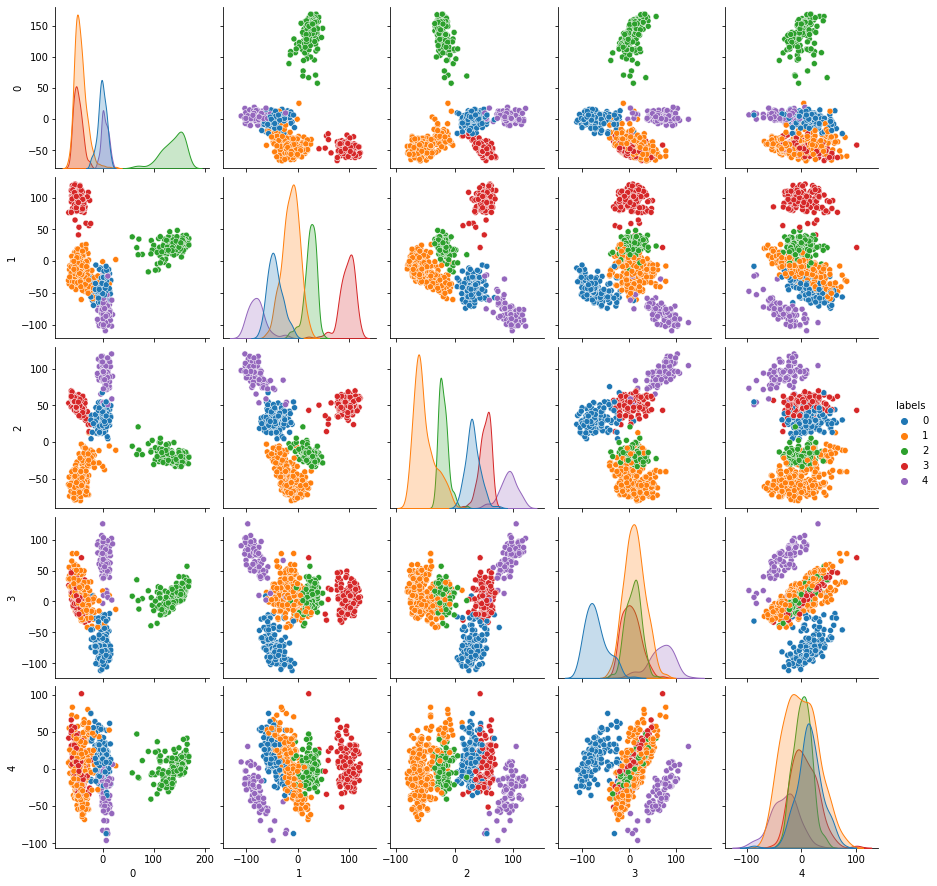

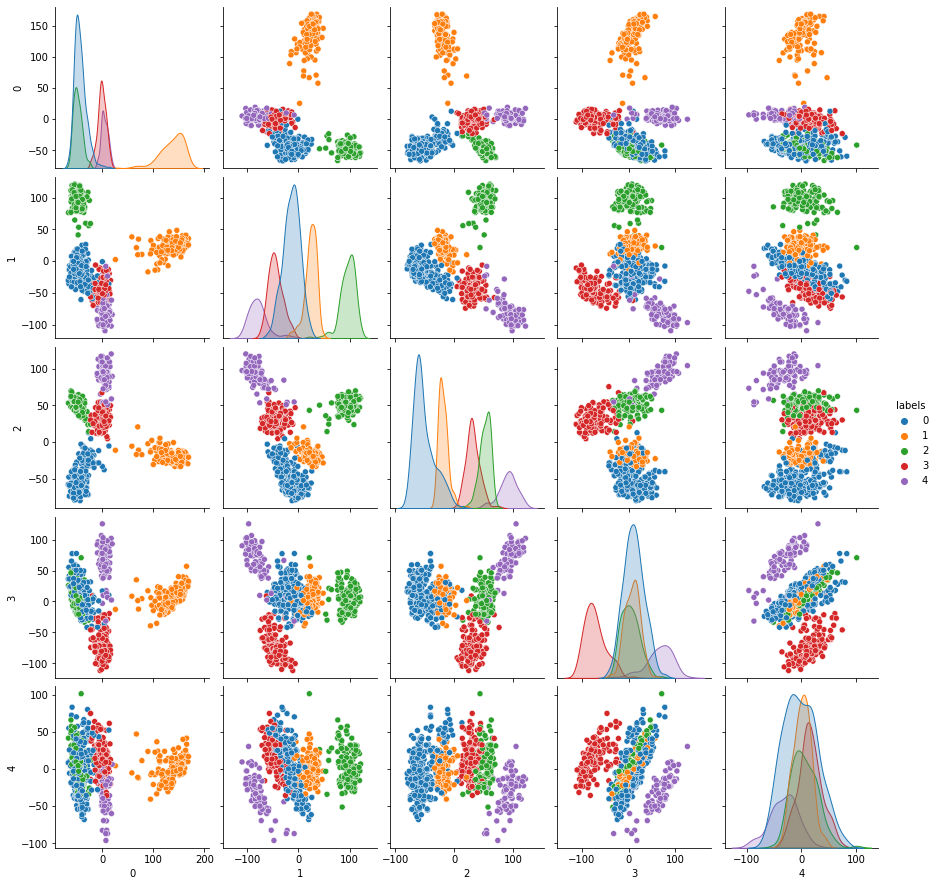

In [18]:

n_clusters = 5
KM_model = KMeans(n_clusters=n_clusters)
KM_model.fit(principalComponents)
prediction_kmeans = KM_model.predict(principalComponents)

GM_model = GaussianMixture(n_components=n_clusters)
GM_model.fit(principalComponents)
prediction_gmm = GM_model.predict(principalComponents)

principalComponents_df = pd.DataFrame(principalComponents)
principalComponents_df_kmeans = deepcopy(principalComponents_df)
principalComponents_df_kmeans['labels'] = prediction_kmeans
principalComponents_df_gmm = deepcopy(principalComponents_df)
principalComponents_df_gmm['labels'] = prediction_gmm


sns.pairplot(principalComponents_df_kmeans, hue='labels', palette="tab10")
sns.pairplot(principalComponents_df_gmm, hue='labels', palette="tab10")


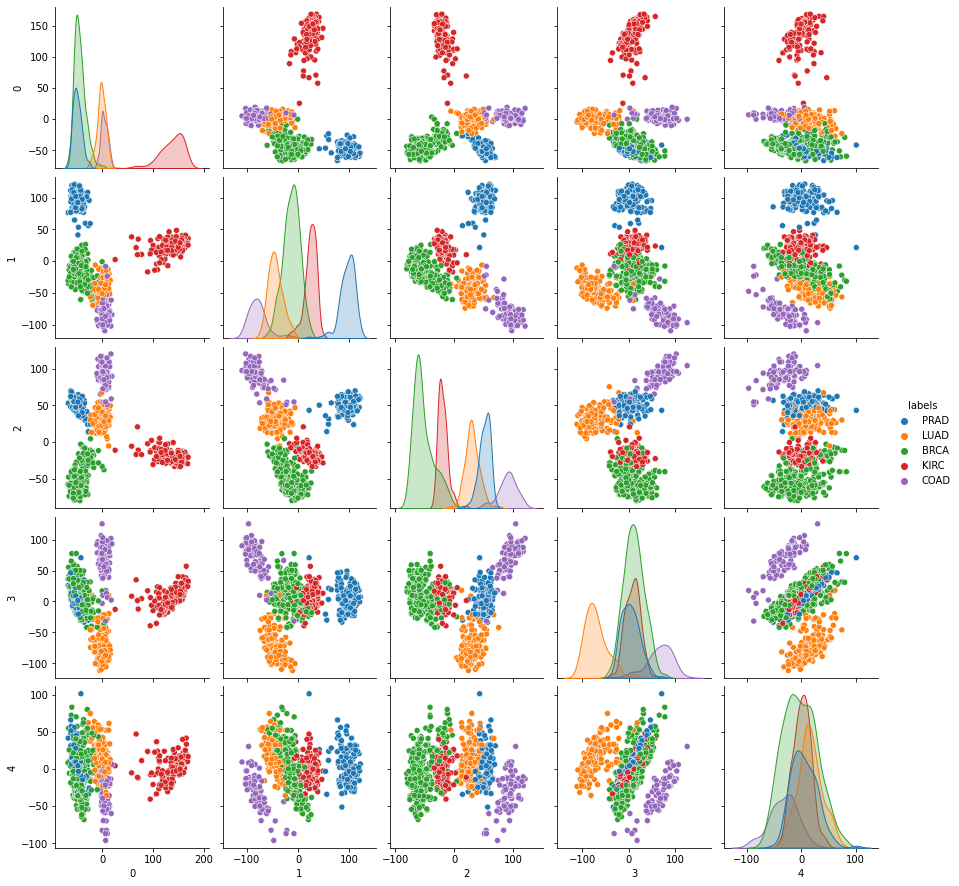

In [19]:
principalComponents_df_labeled = pd.DataFrame(deepcopy(principalComponents))
principalComponents_df_labeled['labels'] = labeled_data.values
sns.pairplot(principalComponents_df_labeled, hue='labels', palette='tab10')

In [20]:
pred_GMs = []
pred_KMs = []
for _ in range(10):
    n_of_clusters = 5
    prediction_GM = GM_model.predict(principalComponents).tolist()
    prediction_KM = KM_model.predict(principalComponents).tolist()

    # Mapping the predicted labels indices to the correct order list
    label_perms = list(permutations(unique))
    best_GM_pred_score = 0
    best_KM_pred_score = 0

    for label_list in label_perms:
        prediction_GM_copy = deepcopy(prediction_GM)
        prediction_KM_copy = deepcopy(prediction_KM)
        for idx, label in enumerate(label_list):
            for jdx, item in enumerate(prediction_GM_copy):
                if item == idx:
                    prediction_GM_copy[jdx] = label
            for jdx, item in enumerate(prediction_KM_copy):
                if item == idx:
                    prediction_KM_copy[jdx] = label            
        
        pred_GM_score = accuracy_score(labeled_data_items, prediction_GM_copy)
        pred_KM_score = accuracy_score(labeled_data_items, prediction_KM_copy)
        if pred_GM_score > best_GM_pred_score:
            correct_GM_label_list = label_list
            best_GM_pred_score = pred_GM_score
            best_GM_prediction_copy = prediction_GM_copy
        if pred_KM_score > best_KM_pred_score:
            correct_KM_label_list = label_list
            best_KM_pred_score = pred_KM_score
            best_KM_prediction_copy = prediction_KM_copy

    pred_GMs.append(best_GM_pred_score)
    pred_KMs.append(best_KM_pred_score) 




In [21]:
# Just making sure
print('GM:')
print(np.mean(pred_GMs))
print(pred_GMs)
print('KM:')
print(np.mean(pred_KMs))
print(pred_KMs)


GM:
0.9975031210986266
[0.9975031210986267, 0.9975031210986267, 0.9975031210986267, 0.9975031210986267, 0.9975031210986267, 0.9975031210986267, 0.9975031210986267, 0.9975031210986267, 0.9975031210986267, 0.9975031210986267]
KM:
0.9937578027465668
[0.9937578027465668, 0.9937578027465668, 0.9937578027465668, 0.9937578027465668, 0.9937578027465668, 0.9937578027465668, 0.9937578027465668, 0.9937578027465668, 0.9937578027465668, 0.9937578027465668]


Question 2. Task 5

In [25]:
# Q2
# principalComponents = pca.fit_transform(col_centered.iloc[:10])

principalComponents = pca.fit_transform(colcentered_df)
principalComponents_df = pd.DataFrame(principalComponents)

n_M = 20
n_K = 10
frac = 0.8
n = len(principalComponents)
n_sub = int(np.floor(frac*n))
M = np.zeros([n_M, n_K-2, n, n])
J = np.zeros([n_M, n_K-2, n, n])

for n_cluster in range(2, n_K):
    for m in range(n_M):
        subsample = principalComponents_df.sample(n_sub)
        index_list = subsample.index.values
        KM_model = KMeans(n_clusters=n_cluster)
        KM_model.fit(subsample)
        prediction_kmeans = KM_model.predict(subsample)
        for i in range(n_sub):
            for j in range(n_sub):
                sample_i = prediction_kmeans[i]
                sample_j = prediction_kmeans[j]
                if sample_i == sample_j:
                    sample_i_index = index_list[i]
                    sample_j_index = index_list[j]
                    M[m][n_cluster-2][sample_i_index][sample_j_index] = 1

        for index1 in index_list:
            for index2 in index_list:
                J[m][n_cluster-2][index1][index2] = 1

    
sumJ = sum(J)
sumM = sum(M)
C = np.zeros([n_K-2, n, n])
# print(C.shape)
for n_clusters in range(n_K-2):
    C[n_clusters] = np.divide(sumM[n_clusters], sumJ[n_clusters])

Cflat = []
for n_c in range(n_K-2):
    Cflat.append(C[n_c].flatten())
    Cflat[n_c].sort()






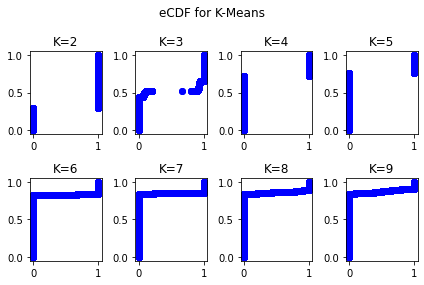

In [26]:
fig, ax = plt.subplots(2, 4)
c_k = 0

q1 = 0.01
q2 = 0.99
PAC = []
ids = np.arange(len(Cflat[0]))

for c_i in ax:
    for c_j in c_i :
        x = np.array(Cflat[c_k])
        y = np.arange(len(x))/float(len(x))

        id1 = np.where(x > q1, ids, 0)
        id2 = np.where(x < q2, ids, 0)

        id1 = id1[id1 != 0]
        id2 = id2[id2 != 0]
        
        fq1 = y[id1[0]]
        fq2 = y[id2[-1]]

        PAC.append(fq2-fq1)

        c_j.scatter(x, y, color='blue')
        c_j.set_title(f'K={c_k+2}')
        c_k += 1
plt.suptitle('eCDF for K-Means')
plt.tight_layout()

[-1.5586010620460833e-06, 0.2106838985600084, -1.5586010619905721e-06, -1.5586010619905721e-06, 0.017164873496144817, 0.014072608989075808, 0.0582153082679111, 0.06442789210116573]


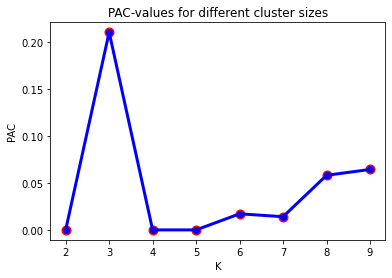

In [27]:
plt.plot(range(2, 10), PAC, '-o', color='blue', linewidth=3, zorder=2)
plt.scatter(range(2, 10), PAC, color='red', linewidths=4, zorder=1)
plt.title('PAC-values for different cluster sizes')
plt.xlabel('K')
plt.ylabel('PAC')
print(PAC)

THEME - DBSCAN

There are so many clustering methods to choose from. Select one from the book or other sources. Make sure you understand the underlying assumptions of the method, apply it to this data and compare to your previous findings.

DBSCAN: Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density. 

An abstract description of the algorithm:
1. Find the points in the $ \epsilon $ neighborhood of every point, and identify the core points with more than minPts neighbors.

2. Find the connected components of core points on the neighborhood graph, ignoring all non-core points. 

3. Assign each non-core point to a nearby cluster if the cluster is an $ \epsilon $ nieghbor, otherwise assign it to noise. 

A naive implementation of this requires storing the neighborhoods in step 1, thus requiring substantial memory. The original DBSCAN algorithm does not require this by performing these steps for one point at a time.

Advantages:

1. Does not require a certain cluster size, it determines that on it's own with the other parameters you give it.

2. DBSCAN can find clusters with arbitrarily shapes. Can for example find cluster surrounded by other cluster as long as the paramters are correctly given.

3. Has mechanism for noise and is therefor robust to outliers.

4. Requires only two parameters. 

Disadvantages:

1. The model is not entirely deterministic. 

2. The method depends heavily on the distance function chosen and is therefor rendered almost useless for high dimensionality due to the curse of dimensionality, but that is true for many other clustering algorithms as well.

3. Can't cluster data sets well with large differences in density. 

4. If the data and scale are not well understood, choosing a meaningful distance threshold $ \epsilon $ might be difficult.

Assumptions about DBSCAN:

One of the advantages of DBSCAN is that it identifies irregularly shaped clusters. 



In [61]:
n_components = 5
pca = PCA(n_components)
dataset = pca.fit_transform(colcentered_df)

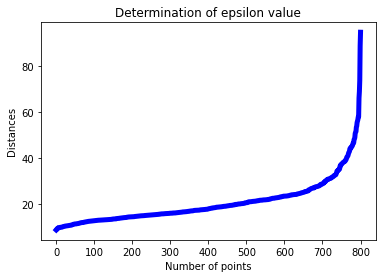

In [159]:
# Determine the value of epsilon
from sklearn.neighbors import NearestNeighbors

n_min = 10
neigh = NearestNeighbors(n_neighbors=n_min)
nbrs = neigh.fit(dataset)

distances, indicies = nbrs.kneighbors(dataset)

distances = np.sort(distances[:, n_min-1])

plt.plot(distances, linewidth=5, color='blue')
#plt.hlines(y=20, xmin=0, xmax=len(distances), color='red')
plt.xlabel('Number of points')
plt.ylabel('Distances')
plt.title('Determination of epsilon value')
plt.show()


In [132]:
from sklearn.cluster import DBSCAN

epsilons = np.arange(10, 60, 5)
n_of_noise_points = []
n_of_clusters = []
silhouette_scores = []
db_scores = []

for epsilon in epsilons:
      db = DBSCAN(eps=epsilon).fit(dataset)
      core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
      core_samples_mask[db.core_sample_indices_] = True
      labels = db.labels_
      n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
      n_noise_ = list(labels).count(-1)
      n_of_clusters.append(n_clusters_)
      n_of_noise_points.append(n_noise_)
      silhouette_scores.append(silhouette_score(dataset, labels))
      db_scores.append(davies_bouldin_score(dataset, labels))




Estimated number of clusters: 5
Estimated number of noise points: 6
Silhouette Coefficient: 0.620


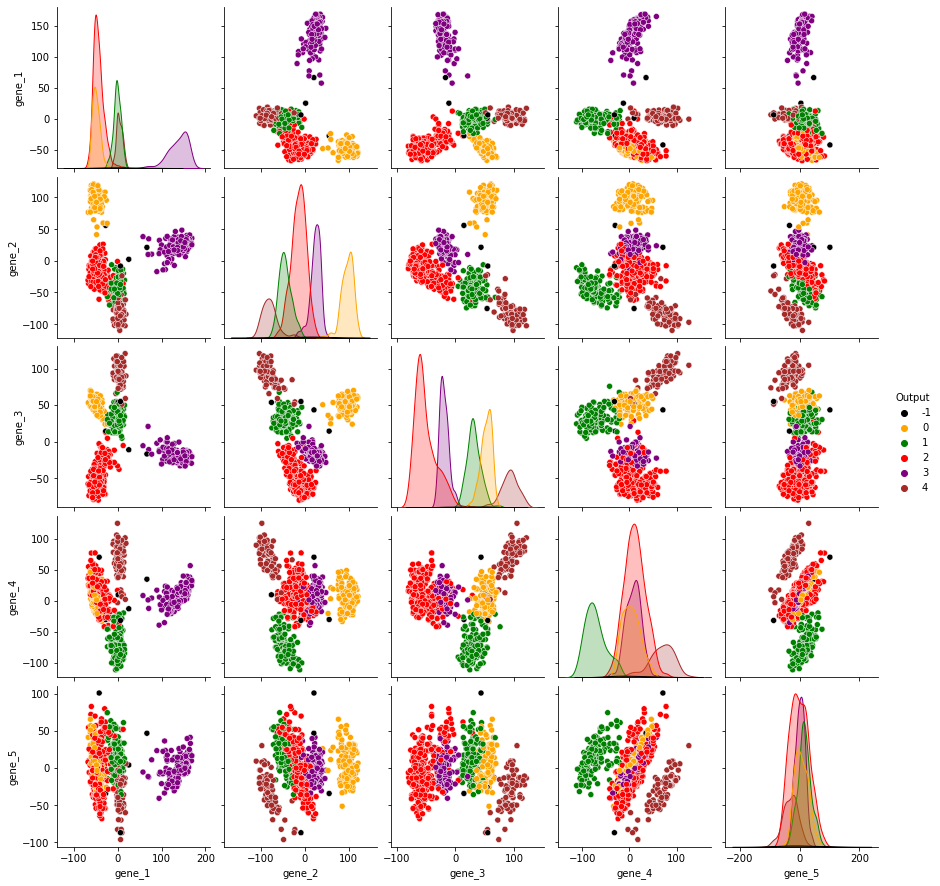

In [195]:
db = DBSCAN(eps=40).fit(dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(dataset, labels))
silhouette_scores.append(silhouette_score(dataset, labels))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
columns_data = [f'gene_{i}' for i in range(1, 5+1)]
rows_data = [f'sample_{i}' for i in range(1, 802)]
df = pd.DataFrame(dataset, columns=columns_data, index=rows_data)
df['Output'] = labels
sns.pairplot(df, hue='Output', palette=['black', 'orange', 'green', 'red', 'purple', 'brown'])

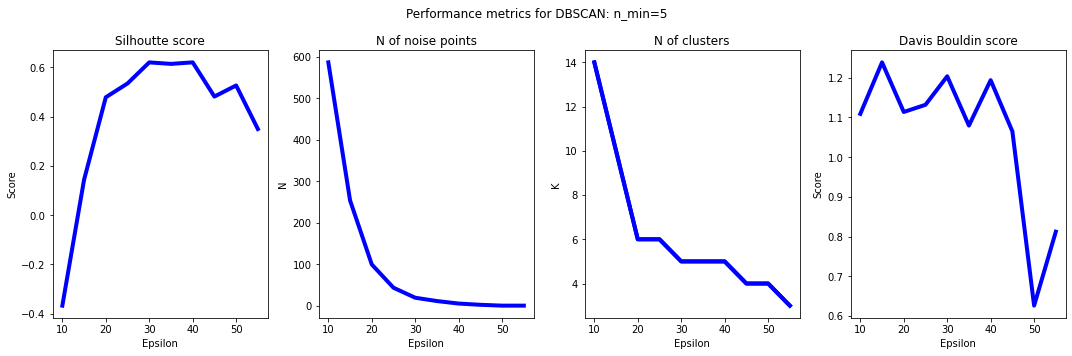

In [134]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(epsilons, silhouette_scores, color='blue', linewidth=4)
ax1.set_title('Silhoutte score')
ax1.set_xlabel('Epsilon')
ax1.set_ylabel('Score')
ax2.plot(epsilons, n_of_noise_points, color='blue', linewidth=4)
ax2.set_title('N of noise points')
ax2.set_xlabel('Epsilon')
ax2.set_ylabel('N')

ax3.plot(epsilons, n_of_clusters, color='blue', linewidth=4)
ax3.set_title('N of clusters')
ax3.set_xlabel('Epsilon')
ax3.set_ylabel('K')

ax3.plot(epsilons, n_of_clusters, color='blue', linewidth=4)
ax3.set_title('N of clusters')
ax3.set_xlabel('Epsilon')
ax3.set_ylabel('K')

ax4.plot(epsilons, db_scores, color='blue', linewidth=4)
ax4.set_title('Davis Bouldin score')
ax4.set_xlabel('Epsilon')
ax4.set_ylabel('Score')

plt.suptitle(f'Performance metrics for DBSCAN: n_min=5')
plt.tight_layout()

In [190]:
# Calculating accuracy score from the predictions and comparing to true labels
pred_DB = []
for _ in range(10):
    n_of_clusters = 5
    db = DBSCAN(eps=40).fit(dataset)
    prediction_DB = db.labels_


    # Mapping the predicted labels indices to the correct order list
    label_perms = list(permutations(unique))
    best_DB_pred_score = 0

    for label_list in label_perms:
        prediction_DB_copy = deepcopy(prediction_DB)
        bad_indices = np.where(prediction_DB_copy == -1)[0]
        prediction_DB_copy = prediction_DB_copy[prediction_DB_copy != -1]

        prediction_DB_copy_labels = np.zeros(len(prediction_DB_copy), dtype=str).tolist()
        for idx, label in enumerate(label_list):
            for jdx, item in enumerate(prediction_DB_copy):
                if item == idx:
                    prediction_DB_copy_labels[jdx] = label
                          
        labeled_data_items_copy = deepcopy(labeled_data_items)
        labeled_data_items_copy = np.delete(labeled_data_items_copy, bad_indices)
        pred_DB_score = accuracy_score(labeled_data_items_copy, prediction_DB_copy_labels)
        if pred_DB_score > best_DB_pred_score:
            correct_DB_label_list = label_list
            best_DB_pred_score = pred_DB_score
            best_DB_prediction_copy = prediction_DB_copy

    pred_DB.append(best_DB_pred_score)



In [200]:
print(f'Average prediction value for DBSCAN: {np.mean(pred_DB):.4f}')

Average prediction value for DBSCAN: 0.9962
